<a href="https://colab.research.google.com/github/rafiarnouk/nba-ml-analysis/blob/main/NBA_Analysis.ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>

Notes
https://www.kaggle.com/code/vbmokin/50-advanced-tips-data-science-tabular-data-v2

##Gathering and Preparing Data##

###General Imports###

In [ ]:
# Imports
import pandas as pd
import numpy as np
import seaborn as sns
import matplotlib.pyplot as plt
from typing import Literal

###Scraping Data###

In [ ]:
import requests
from bs4 import BeautifulSoup

In [ ]:
# Get player data for a given season from basketball-reference.com
def get_season_player_data(season: str, stats_type: Literal["per_game", "advanced"]) -> pd.DataFrame:
    url = f"https://www.basketball-reference.com/leagues/NBA_{season}_{stats_type}.html"

    response = requests.get(url)
    response.raise_for_status()

    soup = BeautifulSoup(response.content, "html.parser")

    table = soup.find("table", {"id": f"{stats_type}_stats"})

    headers = [th.getText() for th in table.find_all("tr", limit=2)[0].find_all("th")][1:]

    rows = table.find_all("tr")[1:]
    player_stats = [[td.getText() for td in rows[i].find_all("td")] for i in range(len(rows))]

    df = pd.DataFrame(player_stats, columns=headers)

    return df

In [ ]:
# Get basic and advanced data for seasons of interest
seasons_to_pull = ["2019", "2020", "2021", "2022", "2023", "2024"]

for season in seasons_to_pull:
    season_data = get_season_player_data(season, "per_game")
    season_data.to_csv(f"season_data_{season}.csv", index=False)

###Preparing Data###

In [ ]:
# Create dictionary with dataframes
season_data_dict = {}

for season in seasons_to_pull:
    season_data_dict[season] = pd.read_csv(f"season_data_{season}.csv")

In [ ]:
# Create function to remove partial rows (extra rows for players that played for multiple teams in one season)
def remove_extra_player_rows(df: pd.DataFrame) -> pd.DataFrame:
    df = df.groupby("Player", sort=False).first().reset_index()
    return df

In [ ]:
# Create function to join player season data with player advanced season data
def join_season_data(season_data_df: pd.DataFrame, season_data_advanced_df: pd.DataFrame) -> pd.DataFrame:
    # Add drop flag suffix to columns in right df that are also in left so they can be filtered out
    drop_flag = "DROP"
    df = pd.merge(
        season_data_df,
        season_data_advanced_df,
        on=["Player", "Tm"],
        how="left",
        suffixes=("", drop_flag)
    )
    columns_to_drop = df.filter(regex=f"{drop_flag}$").columns
    df = df.drop(columns=columns_to_drop)
    return df

In [ ]:
# Create function to remove gap columns from dataframe
def remove_gap_columns(df: pd.DataFrame) -> pd.DataFrame:
    df = df.drop(columns=[column_name for column_name in df.columns
                          if u"\xa0" in column_name])
    return df

In [ ]:
# Get dataframes in desired format
season_data_dict = {season: remove_extra_player_rows(df) for season, df in season_data_dict.items()}

In [ ]:
# Separate training and testing data
training_data_seasons = ["2019", "2020", "2021", "2022", "2023"]
testing_data_seasons = ["2024"]

training_df = pd.concat([season_data_dict[season] for season in training_data_seasons])
testing_df = pd.concat([season_data_dict[season] for season in testing_data_seasons])

###Feature Selection###

In [ ]:
# Create correlation matrix, excluding text columns
training_df_no_strings = training_df.select_dtypes(exclude=["object"])
corr_matrix = training_df_no_strings.corr()

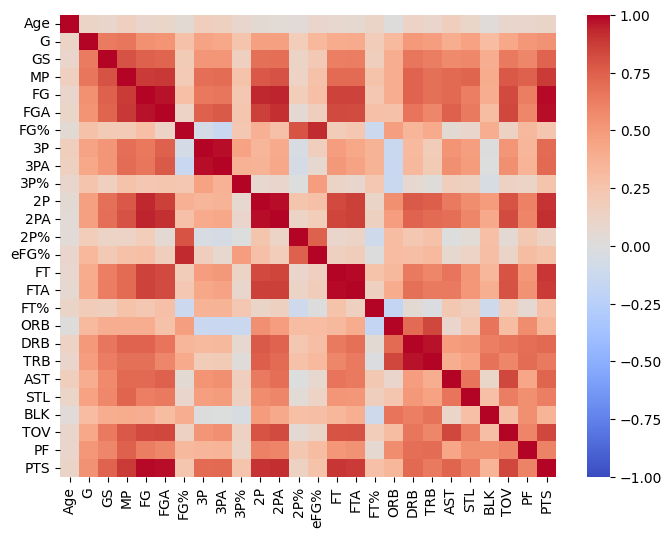

In [ ]:
# Plot correlation matrix
plt.figure(figsize=(8, 6))
sns.heatmap(corr_matrix, cmap="coolwarm", vmin=-1, vmax=1)
plt.show()

In [ ]:
# Identify highly correlated columns
corr_threshold = 0.80
high_corr_map = {column: set() for column in corr_matrix.columns}

for col1 in corr_matrix.columns:
    for col2 in corr_matrix.columns:
        if col1 != col2 and abs(corr_matrix.loc[col1, col2]) > corr_threshold:
            high_corr_map[col1].add(col2)
            high_corr_map[col2].add(col1)

for col, correlated_cols in high_corr_map.items():
    if correlated_cols:
        print(f"Columns highly correlated with {col}: {correlated_cols}")

Columns highly correlated with GS: {'MP'}
Columns highly correlated with MP: {'GS', 'FG', 'FGA', 'PTS'}
Columns highly correlated with FG: {'FTA', '2PA', 'FT', '2P', 'TOV', 'PTS', 'MP', 'FGA'}
Columns highly correlated with FGA: {'FTA', '2PA', 'FT', '2P', 'FG', 'TOV', 'PTS', 'MP'}
Columns highly correlated with FG%: {'eFG%'}
Columns highly correlated with 3P: {'3PA'}
Columns highly correlated with 3PA: {'3P'}
Columns highly correlated with 2P: {'FTA', '2PA', 'FT', 'FG', 'PTS', 'FGA'}
Columns highly correlated with 2PA: {'FTA', 'FT', '2P', 'FG', 'TOV', 'PTS', 'FGA'}
Columns highly correlated with eFG%: {'FG%'}
Columns highly correlated with FT: {'FTA', '2PA', '2P', 'FG', 'PTS', 'FGA'}
Columns highly correlated with FTA: {'2PA', 'FT', '2P', 'FG', 'PTS', 'FGA'}
Columns highly correlated with ORB: {'TRB'}
Columns highly correlated with DRB: {'TRB'}
Columns highly correlated with TRB: {'DRB', 'ORB'}
Columns highly correlated with AST: {'TOV'}
Columns highly correlated with TOV: {'2PA', 'FG'

In [ ]:
import networkx as nx

In [ ]:
# Make groupings of correlated columns so we can decide what to keep
high_corr_graph = nx.Graph()
for node, neighbors in high_corr_map.items():
    for neighbor in neighbors:
        high_corr_graph.add_edge(node, neighbor)

high_corr_groups = list(nx.connected_components(high_corr_graph))

for i, high_corr_group in enumerate(high_corr_groups):
    print(f"Group {i + 1}: {high_corr_group}")

Group 1: {'FTA', '2PA', 'FT', '2P', 'FG', 'PTS', 'TOV', 'AST', 'MP', 'GS', 'FGA'}
Group 2: {'eFG%', 'FG%'}
Group 3: {'3PA', '3P'}
Group 4: {'DRB', 'TRB', 'ORB'}


##Task 1: Finding Similar Players##

Notes:
- Shouldn't use certain columns (age, mp,...)
- Convert position to number? (PG -> 1, SG -> 2,...)

In [ ]:
from sklearn.preprocessing import StandardScaler, MinMaxScaler
from sklearn.neighbors import NearestNeighbors

In [ ]:
# Create function to find similar players to a given player in a given season
default_irrelevant_columns = ["Age", "G", "GS", "MP"]

def find_similar_players(player: str, season: int = "2024", n_similar_players: int = 3,
                         irrelevant_columns: list[str] = default_irrelevant_columns,
                         drop_input_player_row: bool = False):
    # Prepare df
    df = season_data_dict[season]
    if player not in df["Player"].values:
        raise ValueError(f"""
        No player with name {player} found in season data for season {season}.
        """)
    df_dropped_na = df.dropna().reset_index(drop=True)
    df_dropped_irrelevant_columns = df_dropped_na.drop(columns=irrelevant_columns, errors="ignore")
    df_numerical_only = df_dropped_irrelevant_columns.select_dtypes(include=["int64", "float64"])

    # Normalize data
    scaler = StandardScaler()
    arr_scaled = scaler.fit_transform(df_numerical_only)
    df_scaled = pd.DataFrame(arr_scaled, columns=df_numerical_only.columns)

    # Fit KNN
    knn = NearestNeighbors(n_neighbors=n_similar_players + 1, metric="euclidean")
    knn.fit(df_scaled)

    # Find similar players for a given player
    player_index = df_dropped_na[df_dropped_na["Player"] == player].index[0]
    player_row = df_scaled.iloc[player_index].values.reshape(1, -1)
    distances, indices = knn.kneighbors(player_row)

    # Get the indices of similar players
    similar_players_indices = indices[0]
    similar_players_df = df_dropped_na.iloc[similar_players_indices].reset_index(drop=True)

    # Most similar player found must be the input player, so remove first row
    if drop_input_player_row:
        if similar_players_df.at[0, "Player"] == player:
            similar_players_df = similar_players_df.drop(index=0).reset_index(drop=True)
        else:
            raise Exception("""
            Something went wrong. The most similar player did not match the input player.
            """)

    # Communicate results
    return similar_players_df

/usr/local/lib/python3.10/dist-packages/sklearn/base.py:465: UserWarning: X does not have valid feature names, but NearestNeighbors was fitted with feature names
  warnings.warn(


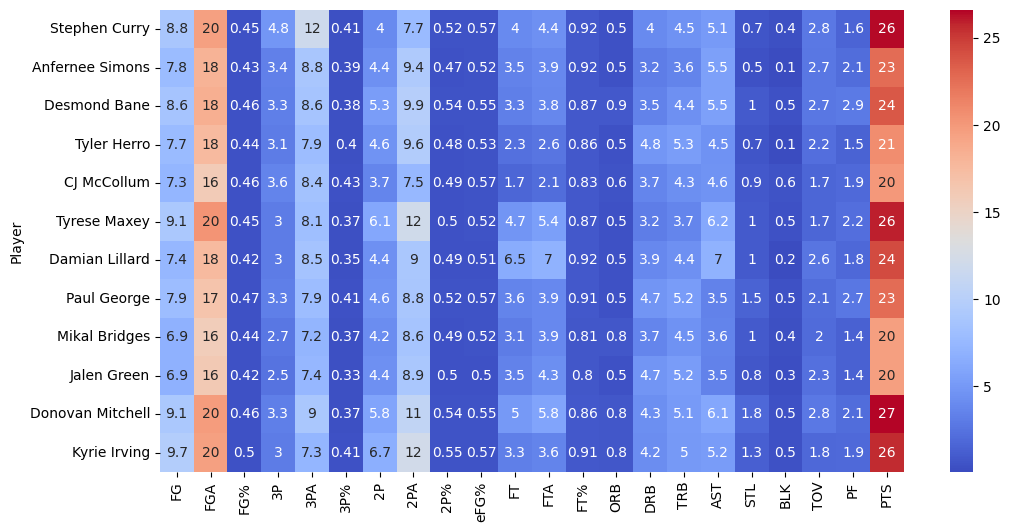

In [ ]:
# Test similar players finder
test_player = "Stephen Curry"
similar_players_df = find_similar_players(test_player, n_similar_players=11)
similar_players_df = similar_players_df.drop(columns=default_irrelevant_columns)
similar_players = similar_players_df["Player"].tolist()

# Plot similar players
plt.figure(figsize=(12, 6))
similar_players_df_for_heatmap = similar_players_df.set_index("Player")
similar_players_df_for_heatmap.drop(columns=["Pos", "Tm"], inplace=True)
sns.heatmap(similar_players_df_for_heatmap, cmap="coolwarm", annot=True)

plt.show()